In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from datasets import load_dataset
from transformers import AutoTokenizer, set_seed
from classifier import TextClassifier
import torch
import numpy as np
import torch.nn.functional as F

In [94]:
set_seed(101)

In [ ]:
# Download weights path here: 
base_model_name = "Alibaba-NLP/gte-multilingual-base"
model_max_length = 64
num_classes = 2
device = "cuda"

In [96]:
dataset = load_dataset("jxie/anti-lgbt-cyberbullying")

In [97]:
model = TextClassifier(base_model_name=base_model_name, num_classes=num_classes).to(device)

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
state_dict = torch.load("Alibaba-NLP-gte-multilingual-base.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [99]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, model_max_length=model_max_length)

In [100]:
reference_labels = np.array(dataset["test"]["label"])

In [101]:
from tqdm import tqdm
@torch.inference_mode()
def predict_texts(texts, model, tokenizer, max_batch_size=16, device="cuda"):
    probs = []
    for start_idx in tqdm(range(0, len(texts), max_batch_size)):
        batch_texts = texts[start_idx:start_idx + max_batch_size]
        batch_inputs = tokenizer(batch_texts, padding="max_length", truncation=True, return_tensors="pt").to(device)
        batch_logits = model(**batch_inputs).logits
        batch_probs = F.softmax(batch_logits)
        probs.append(batch_probs.cpu().numpy())
    return np.concatenate(probs)

In [102]:
test_texts = dataset["test"]["text"]
probs = predict_texts(test_texts, model, tokenizer)

  0%|          | 0/41 [00:00<?, ?it/s]

/tmp/user/22597/ipykernel_99222/616938755.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_probs = F.softmax(batch_logits)
100%|██████████| 41/41 [00:00<00:00, 85.63it/s]


In [103]:
predictions = probs.argmax(axis=1)

In [104]:
import evaluate
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")

In [105]:
results = {}
results.update(accuracy_metric.compute(predictions=predictions, references=reference_labels))
results.update(f1_metric.compute(predictions=predictions, references=reference_labels))
results.update(recall_metric.compute(predictions=predictions, references=reference_labels))
results.update(precision_metric.compute(predictions=predictions, references=reference_labels))

In [106]:
results

{'accuracy': 0.9271317829457364,
 'f1': 0.8705234159779615,
 'recall': 0.8777777777777778,
 'precision': 0.8633879781420765}

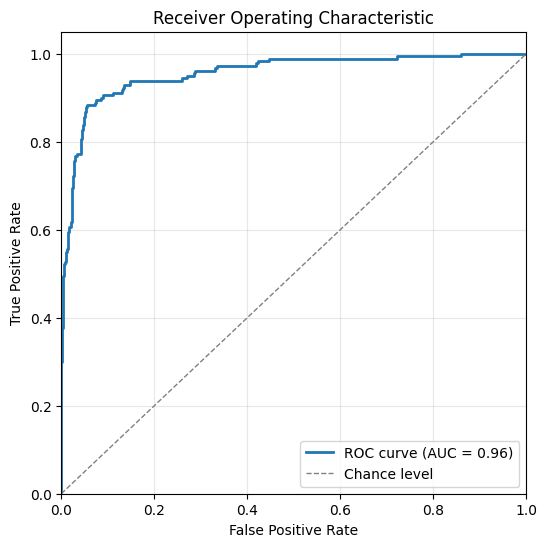

In [108]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_true = reference_labels
y_score = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_score)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance level')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.show()

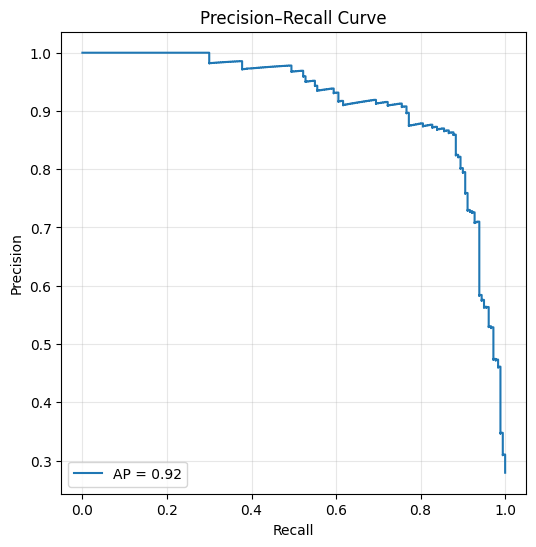

In [109]:
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post', label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()